In [1]:
# Package Import

from torchvision import utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

###1. 데이터셋

In [2]:
# Get Dataset

import os
import random

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

os.makedirs('./dataset', exist_ok=True)
dataset = datasets.STL10('/dataset', split='train', download=True, transform=transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /dataset/stl10_binary.tar.gz to /dataset


###1-1. 8:1:1의 비율로 데이터셋 배분

In [805]:
# Split Dataset to 8 : 1 : 1 Train/Validation/Test

dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
valid_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

print()
print("Train Dataset Size :", len(train_dataset))
print("Valid Dataset Size :", len(valid_dataset))
print("Test Dataset Size :", len(test_dataset))


Train Dataset Size : 4000
Valid Dataset Size : 500
Test Dataset Size : 500


###1-2. 학습 데이터 증강

학습 데이터에 대해 무작위 부분 추출, 무작위 3도 회전, 50%의 확률로 가로로 뒤집기 등의 데이터 증강 기법을 사용했다.

In [806]:
# Applying Augmentation

def get_mean(dataset):
  meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
  meanR = np.mean([m[0] for m in meanRGB])
  meanG = np.mean([m[1] for m in meanRGB])
  meanB = np.mean([m[2] for m in meanRGB])
  return [meanR, meanG, meanB]

def get_std(dataset):
  stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]
  stdR = np.mean([s[0] for s in stdRGB])
  stdG = np.mean([s[1] for s in stdRGB])
  stdB = np.mean([s[2] for s in stdRGB])
  return [stdR, stdG, stdB]

_mean = get_mean(train_dataset)
_std = get_std(train_dataset)

train_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)), transforms.RandomRotation(degrees=3), transforms.RandomHorizontalFlip(p = 0.5), transforms.ToTensor(), transforms.Normalize(_mean, _std)])
valid_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize(_mean, _std)])
test_transform = transforms.Compose([transforms.Resize((96, 96)), transforms.ToTensor(), transforms.Normalize(_mean, _std)])

train_dataset.transform = train_transform
valid_dataset.transform = valid_transform
test_dataset.transform = test_transform


idx_to_class = train_dataset.dataset.classes

###1-3. 데이터로더 초기화

배치 크기는 임의로 지정했으며 학습 데이터를 제외한 나머지 데이터셋에 대해서는 shuffle 옵션을 False로 지정했다.

In [807]:
# DataLoader Initialize

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

###2. 전이 학습

In [808]:
# For Transfer Learning

import torch.nn as nn
from torch import optim

###2-1. 전이 학습을 위한 사전학습 ResNet50 모델 불러오기 및 전연결 레이어를 제외한 모든 레이어 Freeze

전이 학습을 위해 가중치가 높은 초반 레이어는 Freeze하고 후반 레이어를 학습 가능한 상태로 만들었으며, 10개의 클래스로 분류하기 위해 전연결 레이어를 수정했다.

In [809]:
# Pre-Trained(ImageNet) ResNet50 Model

from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True).to(device)

# Layer Freezing
count_layer = 0
for param in model.parameters():
  if count_layer > 60:
    break
  param.requires_grad = False
  count_layer += 1

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 10), 
    nn.LogSoftmax(dim=1)
)
model = model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


###2-2. 학습 및 검증

In [810]:
import time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(valid_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
        avg_train_loss = train_loss/train_size 
        avg_train_acc = train_acc/train_size
        avg_valid_loss = valid_loss/valid_size 
        avg_valid_acc = valid_acc/valid_size
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        epoch_end = time.time()
        print("Epoch: {:02d}, Training: Loss - {:.4f}, Accuracy - {:.2f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.2f}%, Time: {:.2f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

    return model, history, best_epoch

###2-3. 학습 하이퍼 파라미터 설정 및 손실 함수와 최적화 함수 설정

In [811]:
lr = 0.0001
num_epochs = 3
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss().to(device)

###2-4. 학습 진행

In [812]:
trained_model, history, best_epoch = train_and_validate(model, loss_func, optimizer, num_epochs)

Epoch: 1/3
Epoch: 00, Training: Loss - 1.2642, Accuracy - 68.20%, 
		Validation : Loss - 0.3801, Accuracy - 89.40%, Time: 3.04s
Epoch: 2/3
Epoch: 01, Training: Loss - 0.2174, Accuracy - 94.58%, 
		Validation : Loss - 0.2730, Accuracy - 90.60%, Time: 3.04s
Epoch: 3/3
Epoch: 02, Training: Loss - 0.0611, Accuracy - 98.72%, 
		Validation : Loss - 0.2387, Accuracy - 93.20%, Time: 3.02s


###3. 학습 결과

###3-1. 학습 정확도 및 검증 정확도

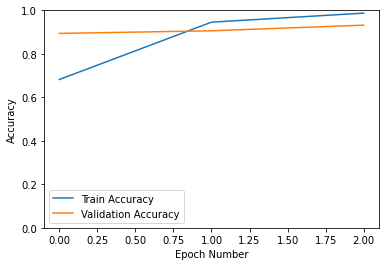

In [813]:
history = np.array(history)
plt.plot(history[:,2:4])
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

###3-2. 학습 로스 및 검증 로스

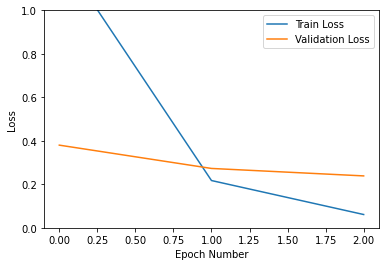

In [814]:
plt.plot(history[:,0:2])
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

###3-3. 시험 정확도 계산

In [828]:
def CalcTestAcc(model, loss_criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    with torch.no_grad():
        model.eval()
        for j, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            test_acc += acc.item() * inputs.size(0)
            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
    avg_test_loss = test_loss/test_size 
    avg_test_acc = test_acc/test_size

    print("Test accuracy : " + str(avg_test_acc))

In [829]:
CalcTestAcc(model, loss_func)

Test Batch number: 000, Test: Loss: 0.2913, Accuracy: 0.8906
Test Batch number: 001, Test: Loss: 0.3578, Accuracy: 0.8906
Test Batch number: 002, Test: Loss: 0.0863, Accuracy: 0.9688
Test Batch number: 003, Test: Loss: 0.1952, Accuracy: 0.9531
Test Batch number: 004, Test: Loss: 0.2141, Accuracy: 0.9375
Test Batch number: 005, Test: Loss: 0.5422, Accuracy: 0.8750
Test Batch number: 006, Test: Loss: 0.1557, Accuracy: 0.9531
Test Batch number: 007, Test: Loss: 0.1086, Accuracy: 0.9615
Test accuracy : 0.9279999971389771


###3-4. 실제 분류 성능 시각화

In [849]:
def visualize_predict(model, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    test_acc = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
        plt.figure(figsize=(15,7))
        for i in range(20):
            plt.subplot(4,5,i+1)
            plt.title("Prediction : " + idx_to_class[pred[i]])
            if pred[i] == labels[i]:
              test_acc += 1
            plt.xticks([])
            plt.yticks([])
            plt.imshow(np.transpose(inputs[i].cpu().numpy(), (1, 2, 0)))
        plt.suptitle("Prediction Accuracy : " + str(test_acc / 20 * 100) + "%" + " (" + str(test_acc) + "/20)", fontsize=14)

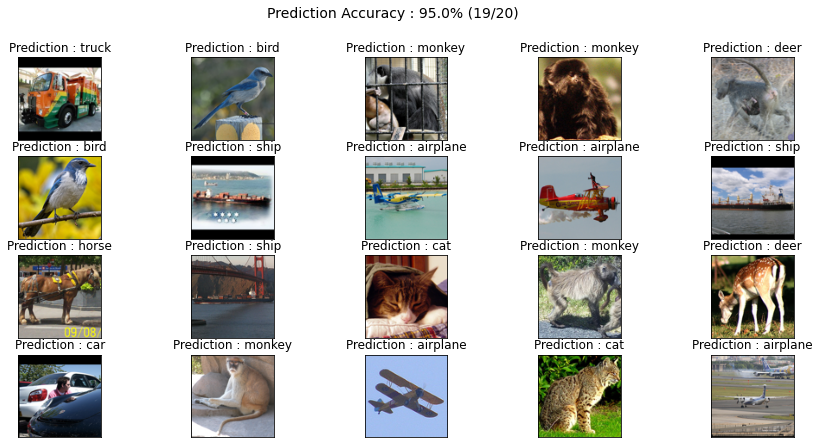

In [850]:
visualize_predict(model, loss_func, test_dataloader)